In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
sys.path

NameError: name 'sys' is not defined

In [2]:
import os
import sys
import pickle as pkl
from argparse import ArgumentParser
from copy import deepcopy
from os.path import join as oj
import numpy as np
import torch
from torch import nn
import torch.utils.data
from torch import optim
import pickle
from torch.utils.data import DataLoader, TensorDataset
sys.path.insert(0, "../1D CNN")
import data_fns
import utils
import pandas as pd
import models
# import cmcrameri.cm as cmc
import torchvision
from matplotlib import pyplot as plt
import matplotlib as mpl
# mpl.rc('image', cmap='cmc.batlow')
cuda = torch.cuda.is_available()
import csv
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
from sklearn import metrics
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

Using device: cpu


[]

In [3]:
file_path = "TS_freq_array_0208_new.csv"
model_path = "C:\\Users\\aethe\\1D CNN"

y_labels = []
x_TS = []
fish_num = []
final_labels = []
# Read the CSV file line by line
with open(file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    
    next(csv_reader)
    
    # Extract the first column and construct rows as arrays
    for row in csv_reader:
        fish_num.append(row[0])
        y_labels.append(row[-2])
        x_TS.append(row[2:-2])
        final_labels.append([row[-2],row[-1]])


x_TS = np.array(x_TS, dtype = float)

print(x_TS.shape) # (32954, 249)

means = np.mean(x_TS, axis=0)
std_devs = np.std(x_TS, axis=0)
x_TS = (x_TS - means) / std_devs  # Standardizing data


# Contruct data and labels
data = x_TS[:, None]
labels = np.array(y_labels, dtype=int)
final_labels = np.array(final_labels, dtype=int)

fish_num_to_index = {fish_num: index for index, fish_num in enumerate(np.unique(np.array(fish_num)))}

# Use the mapping to convert the fish_num to indices
fish_ind = np.array([fish_num_to_index[num] for num in fish_num])


train_idxs_by_fish, val_idxs_by_fish, test_idxs_by_fish = data_fns.get_split(len(np.unique(fish_ind)), seed=23)

def construct_data_index_by_fish_idxs(idxs_split_by_fish, fish_ind):
    indx = np.array([], dtype=int)  # Ensure the array is of integer type
    for split_fish_ind in idxs_split_by_fish:
        # Ensure split_fish_ind is an integer before using it as an index
        split_fish_ind = int(split_fish_ind)
        indx_current_fish = np.where(fish_ind == split_fish_ind)[0]
        indx = np.append(indx, indx_current_fish)

    return indx



# Indices that we use in the model
train_idxs = construct_data_index_by_fish_idxs(train_idxs_by_fish, fish_ind)
val_idxs = construct_data_index_by_fish_idxs(val_idxs_by_fish, fish_ind)
test_idxs = construct_data_index_by_fish_idxs(test_idxs_by_fish, fish_ind)


(32954, 249)


In [4]:
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results_all = pd.concat(results_list, axis=1).T.infer_objects()


In [13]:

# results_all = results_all[results_all.exp_name == "FinalModels"]

In [5]:
used_idxs= test_idxs


In [6]:
model_idx =  results_all.test_auc.argmax()

model = models.FGANet(num_input= data.shape[2],
                      num_in_channels=1, 
                      num_output = 2, 
      
                      conv_channels = 16,
                      stride = 1).to(device)

model.load_state_dict(torch.load(oj(model_path,results_all.iloc[model_idx].filename+".pt")))
model = model.to(device)
model.eval();

In [7]:
pred_y = model.forward(torch.Tensor(data[used_idxs])).detach().cpu().numpy()
true_y = final_labels[used_idxs]

In [8]:
results_all

,filename,exp_name,batch_size,num_epochs,seed,num_conv,patience,train_losses,val_losses,val_acc,best_val_loss,test_loss,test_acc,test_auc
0,6012210458,,128,1000,0,16,10,"[0.5571420119031445, 0.47414431647285, 0.42809...","[0.7098421817872582, 0.6254804061680306, 0.662...","[0.7261289886334574, 0.7710643898768279, 0.774...",0.378914,0.567105,0.823354,0.872259
1,7044950395,,128,1000,0,16,10,"[0.22162266579139364, 0.22167554751529797, 0.2...","[0.4391252725589566, 0.561965724317039, 0.4276...","[0.8396733709049182, 0.8170603917031871, 0.851...",0.379499,0.554650,0.843409,0.884702
2,7168682199,,128,1000,0,16,10,"[0.1178189505833191, 0.1156914397910401, 0.113...","[0.22238429835656795, 0.22151884618328838, 0.2...","[0.8500779951823749, 0.8467288217974107, 0.841...",0.171208,0.276876,0.822307,0.874183
3,7535663810,,128,1000,0,16,10,"[0.5583759385139443, 0.4643348410379055, 0.420...","[0.48662852197885514, 0.4711628343909979, 0.55...","[0.74, 0.7708, 0.7186, 0.7618, 0.7866, 0.8076,...",0.373294,0.589806,0.826136,0.874599


In [9]:
results_all.iloc[model_idx].filename

'7044950395'

# max activation

In [24]:

feature_dataset = TensorDataset(
    *[torch.Tensor(input) for input in [data[used_idxs], final_labels[used_idxs]]]
) 
true_y_feature = final_labels[used_idxs]
features_output= np.zeros(((len(used_idxs),3648)))
feature_loader = DataLoader(feature_dataset, batch_size=128, shuffle=False)
for batch_idx, (
        data_cur,
        label_cur,
    ) in enumerate(feature_loader):
    features_output[batch_idx*128:batch_idx*128+data_cur.shape[0]] = model.features.forward(data_cur).detach().cpu().numpy()

num_channels = 64

features_output = np.reshape(features_output, (len(used_idxs),num_channels, -1 ))
num_outputs = features_output.shape[-1]
features_output = np.swapaxes(features_output, 0,1)

In [10]:
num_outputs

57

In [11]:
num_dataset

NameError: name 'num_dataset' is not defined

In [26]:
num_dataset = features_output.shape[1]


In [30]:
num_samples_all=100
test_out = np.empty((num_channels, num_samples_all,24))

padding =5 
for j in range(num_channels):
    
    test_features = np.copy(features_output[j])[:,padding:-padding] 
    max_idx = test_features.reshape(-1).argsort()[-num_samples_all:]
 
    maxpos_vect = np.column_stack(np.unravel_index(max_idx, ( num_dataset, 57-2*padding)))
#     if j ==0:
#         print(maxpos_vect+padding)
    for i in range(num_samples_all):
        neuron_pos = maxpos_vect[i,1]+padding
        test_out[j,i] =data[used_idxs,0][maxpos_vect[i,0]][(neuron_pos)* 4:(neuron_pos)* 4+24]



In [28]:
import random

def generate_color_codes(num_colors):
    colors = set()
    while len(colors) < num_colors:
        color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
        colors.add(color)
    return list(colors)

color_codes = generate_color_codes(64)
print(color_codes)

['#8007ae', '#2655a2', '#d6449d', '#6cdfc1', '#c724ce', '#059949', '#0b00cf', '#70b42a', '#a1bfea', '#7e3f6b', '#40e88d', '#ae62f9', '#73c632', '#171594', '#f91f92', '#c98d45', '#565be0', '#a79664', '#35b72f', '#126514', '#a5c283', '#7f8a66', '#be5e1f', '#992e16', '#204727', '#43d174', '#4f6d68', '#6c3240', '#e07d39', '#d13a9f', '#623001', '#fb32db', '#b2896a', '#bba027', '#78fdb7', '#278f98', '#271826', '#7f0d6c', '#bdbe55', '#3e507b', '#2247ee', '#124931', '#5ae80c', '#63fe68', '#42a71f', '#054c97', '#90d2a0', '#f9c2fd', '#57d0ac', '#03550c', '#018a9b', '#a73613', '#e8b908', '#dc67e4', '#bcb9b2', '#8032bf', '#dd6959', '#04dd41', '#1c6a02', '#d9fa5b', '#b87261', '#2cdab4', '#ecc33a', '#567100']


C:\Users\aethe\AppData\Local\Temp\ipykernel_39664\1438234489.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Dark2')


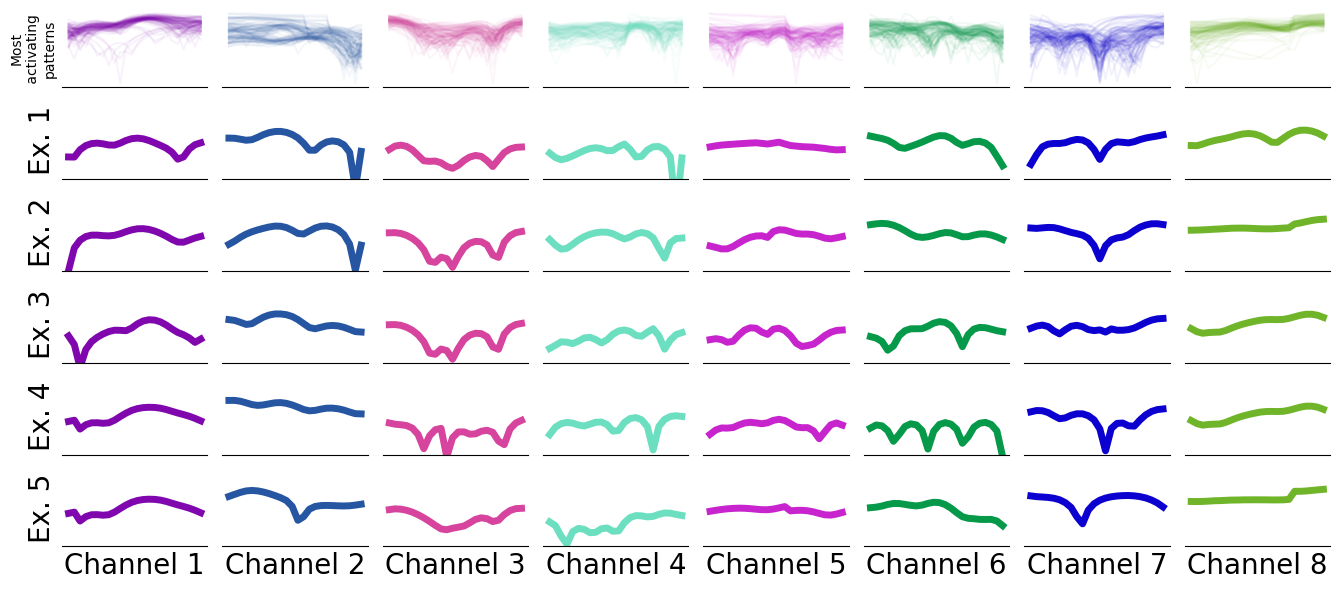

In [31]:
# colors = ['#5a05fa', '#320594', '#11ccb9', '#018786', '#cb3461', '#792039', '#f5660a', '#8e3d0b',
#           '#DFFF00','#FFBF00','#FF7F50','#DE3163', '#9FE2BF','#40E0D0','#6495ED','#CCCCFF',]
colors = color_codes
np.random.seed(0)
num_samples=5
cmap = mpl.cm.get_cmap('Dark2')


fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i].T, c= colors[i], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+1), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([-3,5], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()
plt.savefig('explain_plot.png')

    


In [30]:
test_out[4,my_idxs[4]]

array([3.53583603, 3.61118429, 3.68321379, 3.75313902, 3.79546207,
       3.81338633, 3.82551133, 3.84252559, 3.8891168 , 3.91816566,
       3.9681202 , 4.01127821, 4.03045344, 4.04039226, 4.02778281,
       3.97828804, 3.92396631, 3.84158165, 3.8133513 , 3.8006904 ,
       3.75009483, 3.72094612, 3.68297157, 3.63402056])

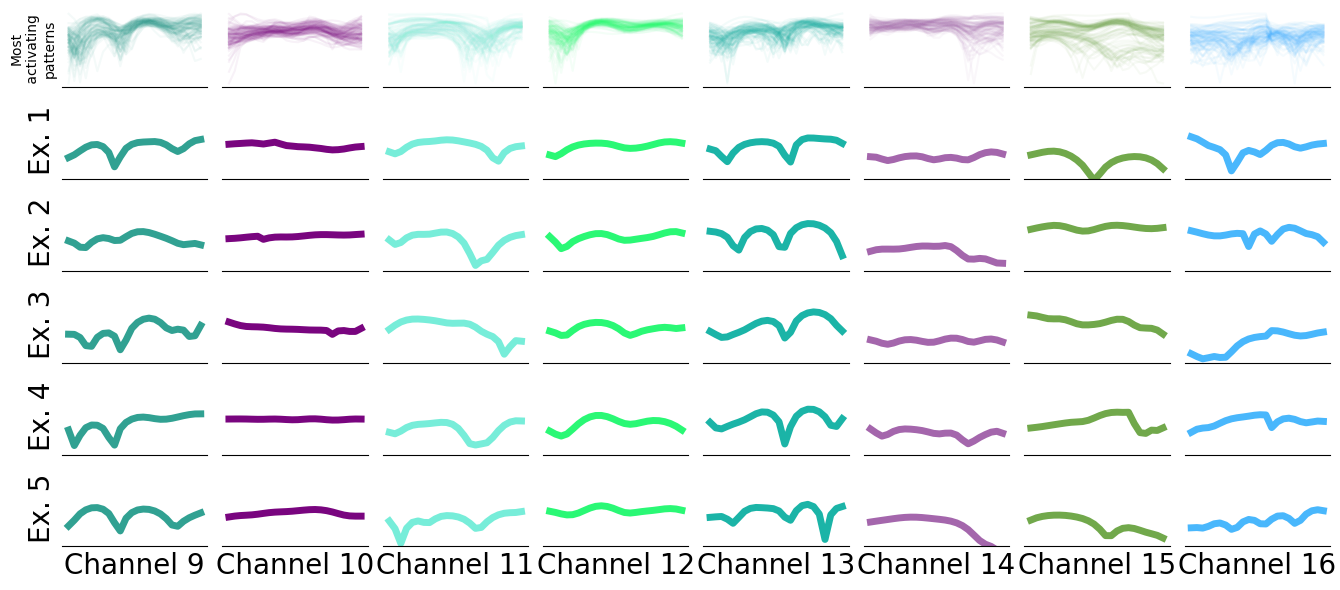

In [16]:

fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i+8].T, c= colors[i+8], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+9), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i+8,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i+8])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([-3,5], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()
plt.savefig('explain_plot_1.png')

In [ ]:
# zoomed in feature

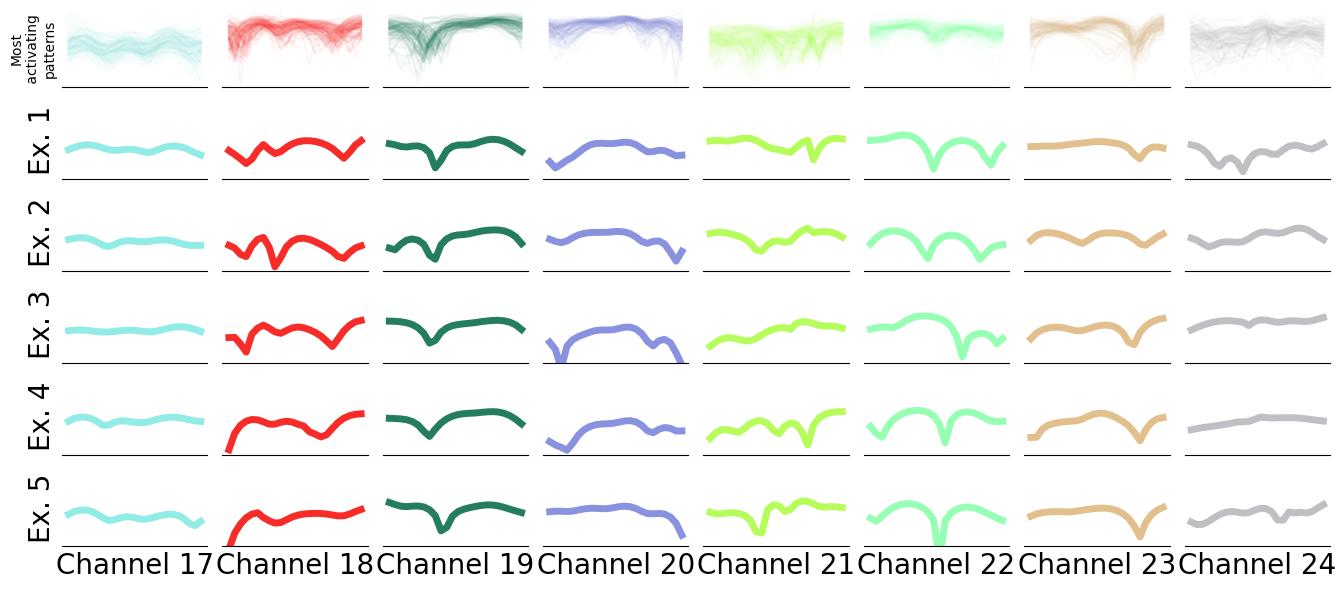

In [17]:
fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i+16].T, c= colors[i+16], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+17), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i+16,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i+16])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([-3,5], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()
plt.savefig('explain_plot_2.png')

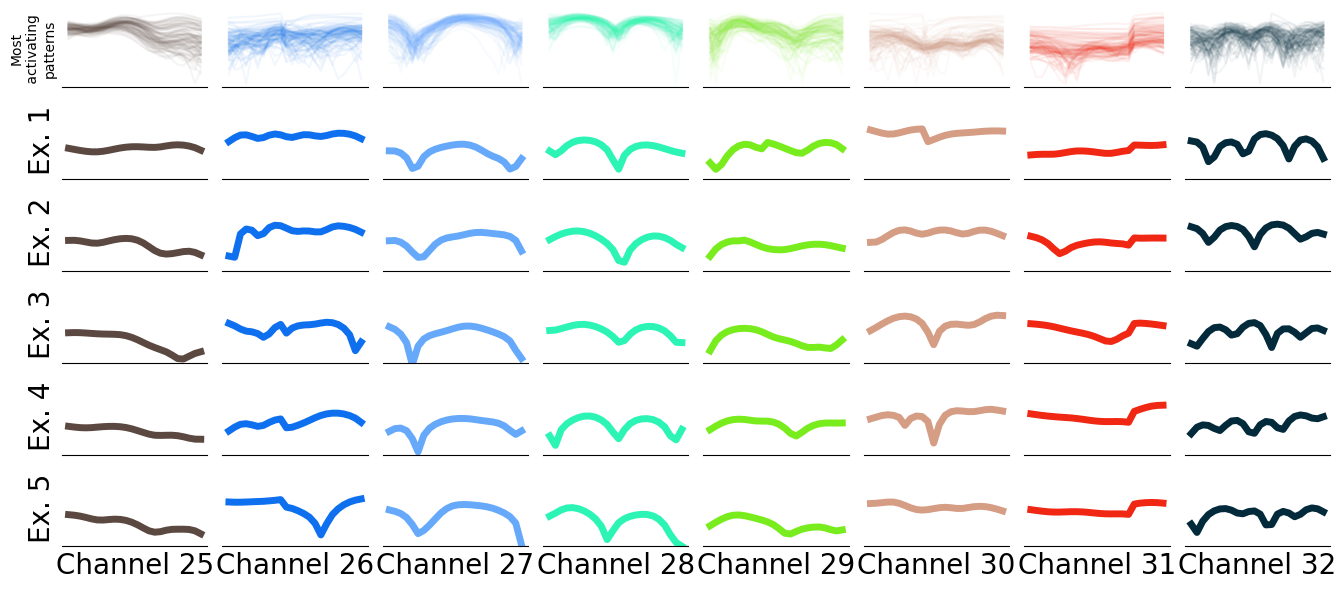

In [18]:
fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i+24].T, c= colors[i+24], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+25), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i+24,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i+24])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([-3,5], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()
plt.savefig('explain_plot_3.png')

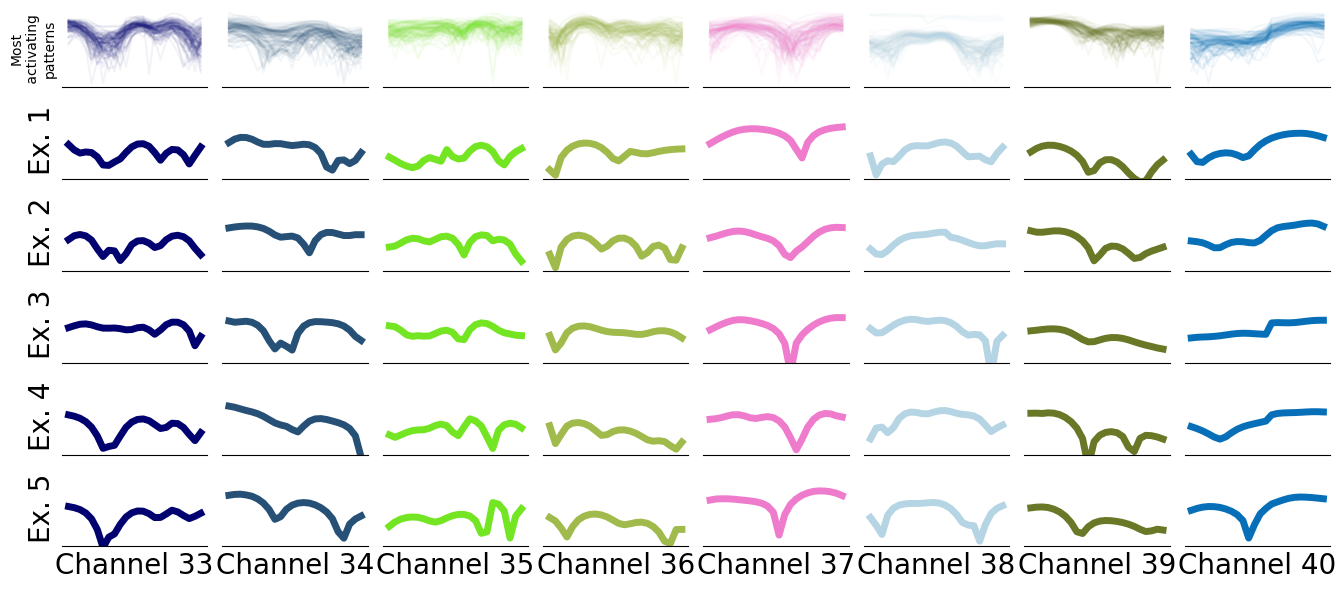

In [22]:
fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i+32].T, c= colors[i+32], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+33), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i+32,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i+32])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([-3,5], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()
plt.savefig('explain_plot_4.png')

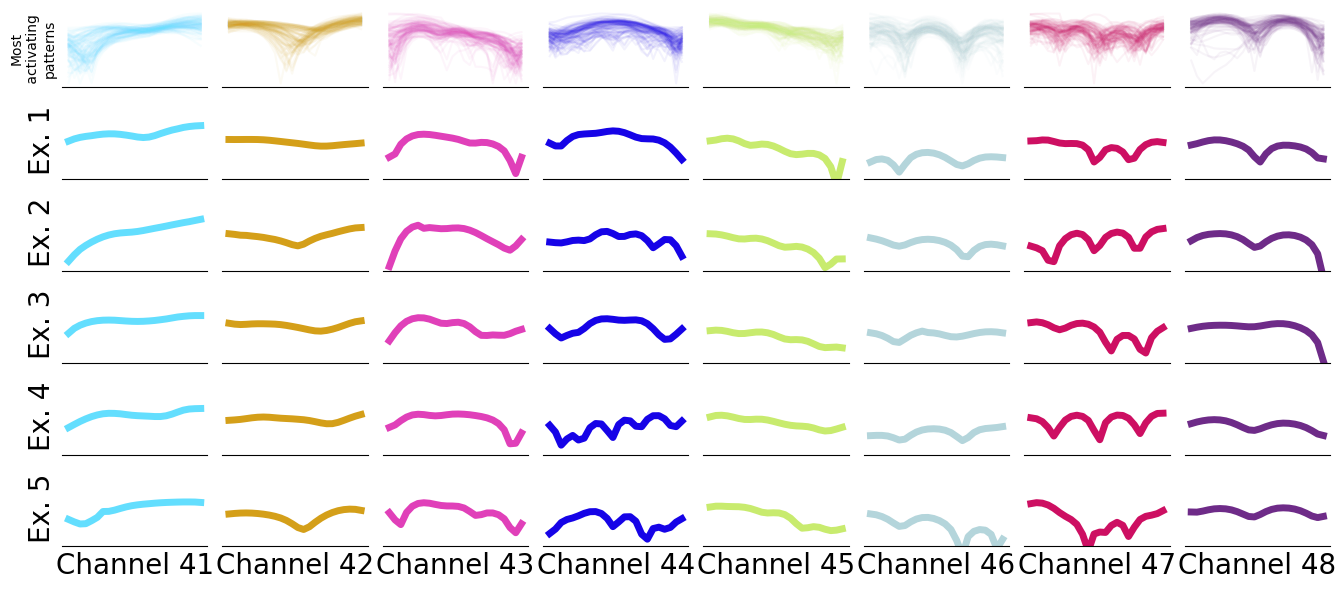

In [23]:
fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i+40].T, c= colors[i+40], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+41), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i+40,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i+40])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([-3,5], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()
plt.savefig('explain_plot_5.png')

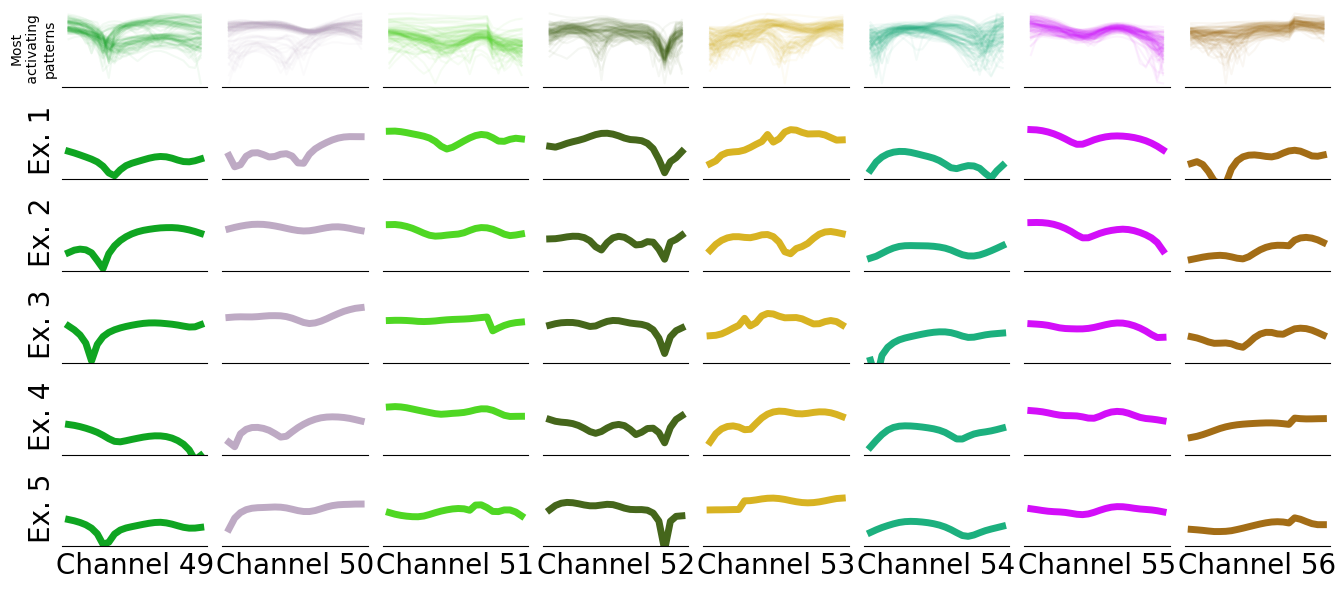

In [25]:
fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i+48].T, c= colors[i+48], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+49), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i+48,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i+48])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([-3,5], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()
plt.savefig('explain_plot_6.png')

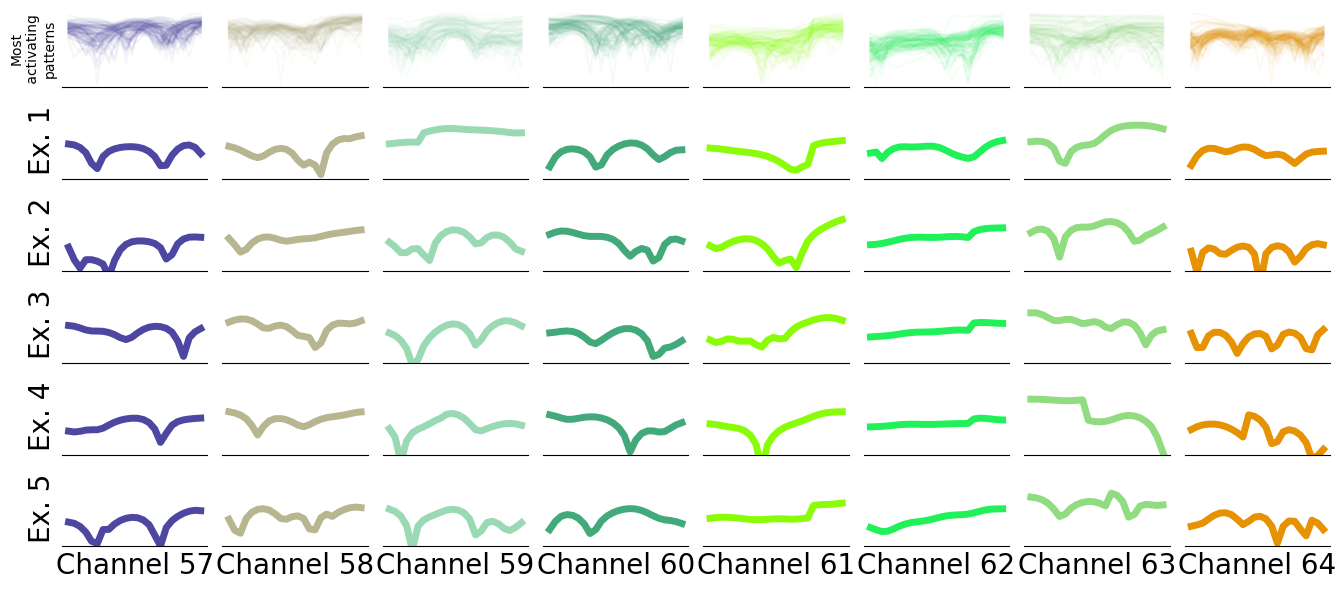

In [26]:
fig, axes = plt.subplots(ncols = 8, 
                         nrows = num_samples+1, 
                         figsize = ((8+1)*1.5, 
                                    (num_samples+1)*1))

for i in range(8):
    axes[0,i].plot(test_out[i+56].T, c= colors[i+56], alpha = .05)
    axes[0,0].set_ylabel("Most\n activating \npatterns", fontsize = 10, rotation = 90)
    axes[-1,i].set_xlabel("Channel {}".format(i+57), fontsize = 20)
#     axes[0,i].set_xlabel("Channel # {}".format(i), )
#     axes[-2,i].xaxis.labelpad = 50
    my_idxs =-np.random.choice(num_samples_all,size=num_samples)

    axes[0,i].set_yticks([]);
    axes[0,i].set_xticks([]);        
    axes[0,i].spines.right.set_visible(False)
    axes[0,i].spines.top.set_visible(False)
        
    axes[0,i].spines.left.set_visible(False)
    for j in range(1,num_samples+1):
        axes[j,0].set_ylabel("Ex. {}".format(j), fontsize = 20,)

#         axes[j,0].set_ylabel("Ex. # {}".format(j-1))

        axes[j,i].plot(test_out[i+56,my_idxs[j-1]], 
                       linewidth =5,  
                       c=  colors[i+56])
        axes[j,i].set_yticks([]);
        axes[j,0].set_yticks([]);
        axes[j,i].spines.right.set_visible(False)
        axes[j,i].spines.top.set_visible(False)
        
        axes[j,i].spines.left.set_visible(False)
   
        

        axes[j,i].set_xticks([]);
        axes[j,i].set_ylim([-3,5], );

    

axes[0,0].set_yticks([]);

plt.tight_layout()
plt.savefig('explain_plot_7.png')

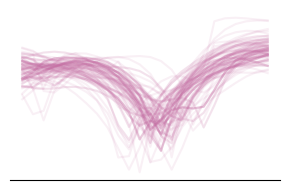

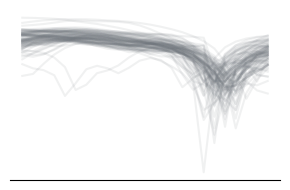

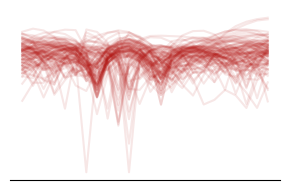

In [35]:




# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
channel_list = [0,1,2]
for i in channel_list:
    fig, axes = plt.subplots(ncols = 1, 
                         nrows = 1, 
                         figsize = (3,2))
    axes.plot(test_out[i].T, c= colors[i], alpha = .1)

#     maxpos_vect = np.column_stack(np.unravel_index(max_idx, ( num_dataset, 209)))
    axes.set_yticks([]);
    axes.set_xticks([]);        
    axes.spines.right.set_visible(False)
    axes.spines.top.set_visible(False)
        
    axes.spines.left.set_visible(False)

        

#         axes[j,i].set_xticks([]);
    axes.set_yticks([]);
#         axes[j,i].set_ylim([0,1.05], );
    plt.tight_layout()

    



# new grad

In [20]:
# x_values = np.arange(45,170.5,0.5)
# elements_to_remove = [90.0, 90.5]
# x_values = x_values[~np.isin(x_values, elements_to_remove)]
# print(x_values)

# b = np.asarray(x_values)
def round_to_half(number):
    return np.round(number * 2) / 2
# plt.xticks(ticks = a,labels = b, fontsize = 20);
num_columns = 57

# Desired start and end of the x-axis
start = 45
end = 170

# Calculate the step size, add 1 to num_columns to get the number of intervals
step = (end - start) / 5
tick_positions = np.arange(start, end + step, step)
tick_positions = round_to_half(tick_positions)
tick_indices = np.linspace(-0.5, 56.5, len(tick_positions))

# Set the tick positions and labels



In [20]:
x_values.shape

NameError: name 'x_values' is not defined

In [30]:
W = model.classifier[0].weight.detach().cpu().numpy()
W.shape

(2, 3648)

<function matplotlib.pyplot.show(close=None, block=None)>

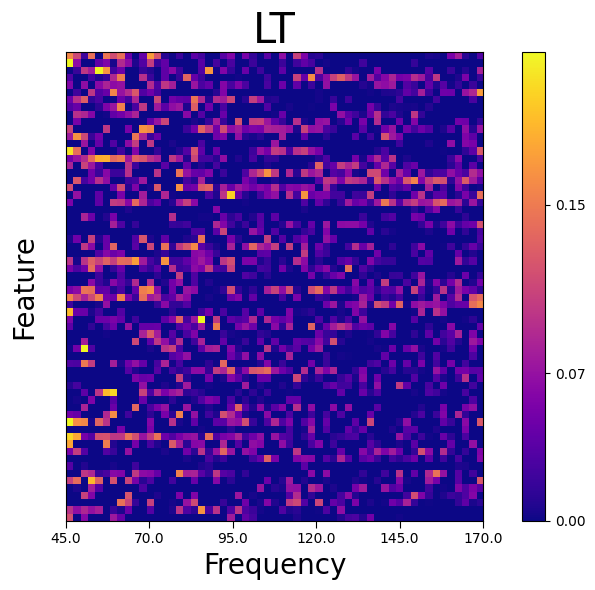

In [22]:
W = model.classifier[0].weight.detach().cpu().numpy()
W = W.reshape((2, 64, -1))
# highest_val = np.percentile(W, 99.9)
lowest_val = 0
# for functional_group in range(17):


W_fun = W[0]
W_fun = np.maximum(0, W_fun)
highest_val = np.percentile(W_fun, 99.9)
fig, ax = plt.subplots(figsize = (8,6))



plt.imshow(W_fun, vmin = lowest_val, vmax = highest_val, cmap =plt.get_cmap('plasma'))
ax.set_xticks(tick_indices)
ax.set_xticklabels([f"{pos:.1f}" for pos in tick_positions])
ax.tick_params(axis='x', which='major', length=5)
plt.yticks([]);
ax.set_xlim(-0.5,56.5)
ax.set_xlabel("Frequency", fontsize =20,)

ax.set_ylabel("Feature", fontsize =20,rotation = 90, labelpad=20)
plt.title("LT", fontsize = 30);
plt.colorbar(ticks = [0, 0.07,.15])
plt.savefig('explain_plot_8.png')
plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

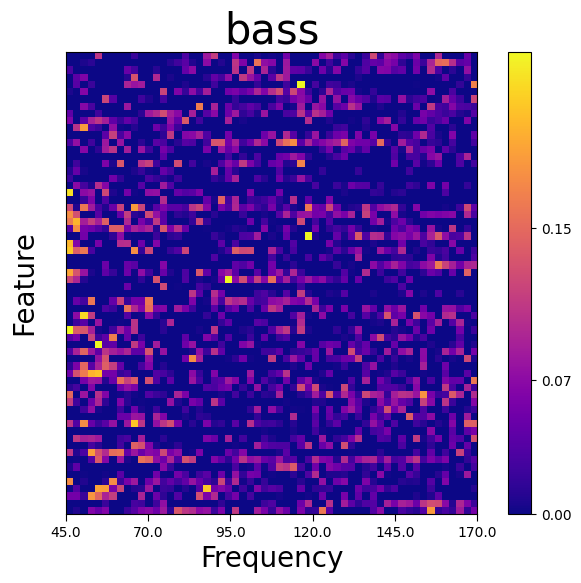

In [23]:
W_fun = W[1]
W_fun = np.maximum(0, W_fun)
highest_val = np.percentile(W_fun, 99.9)
fig, ax = plt.subplots(figsize = (8,6))



plt.imshow(W_fun, vmin = lowest_val, vmax = highest_val, cmap =plt.get_cmap('plasma'))

ax.set_xticks(tick_indices)
ax.set_xticklabels([f"{pos:.1f}" for pos in tick_positions])
ax.tick_params(axis='x', which='major', length=5)
plt.yticks([]);
ax.set_xlim(-0.5,56.5)
ax.set_xlabel("Frequency", fontsize =20,)

ax.set_ylabel("Feature", fontsize =20,rotation = 90, labelpad=20)
plt.title("bass", fontsize = 30);
plt.colorbar(ticks = [0, 0.07,.15])
plt.savefig('explain_plot_9.png')
plt.show